<a href="https://colab.research.google.com/github/zzc029498-max/nec-/blob/main/part3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data prepared: Training samples=400, Test samples=100

HYPERPARAMETER SEARCH - Training Multiple Configurations

[1/12] Training configuration:
  Architecture: [13, 8, 1]
  Epochs: 100, LR: 0.01, Momentum: 0.5, Activation: sigmoid
  Results: MSE=0.0067, MAE=0.0638, MAPE=32.70%

[2/12] Training configuration:
  Architecture: [13, 8, 1]
  Epochs: 100, LR: 0.05, Momentum: 0.7, Activation: sigmoid
  Results: MSE=0.0085, MAE=0.0730, MAPE=32.86%

[3/12] Training configuration:
  Architecture: [13, 10, 5, 1]
  Epochs: 150, LR: 0.03, Momentum: 0.8, Activation: tanh
  Results: MSE=0.0140, MAE=0.0806, MAPE=77.76%

[4/12] Training configuration:
  Architecture: [13, 10, 5, 1]
  Epochs: 200, LR: 0.05, Momentum: 0.9, Activation: tanh
  Results: MSE=0.0149, MAE=0.0872, MAPE=335.46%

[5/12] Training configuration:
  Architecture: [13, 15, 8, 1]
  Epochs: 150, LR: 0.01, Momentum: 0.7, Activation: relu
  Results: MSE=0.0064, MAE=0.0644, MAPE=107.30%

[6/12] Training configuration:
  Architecture: [13, 

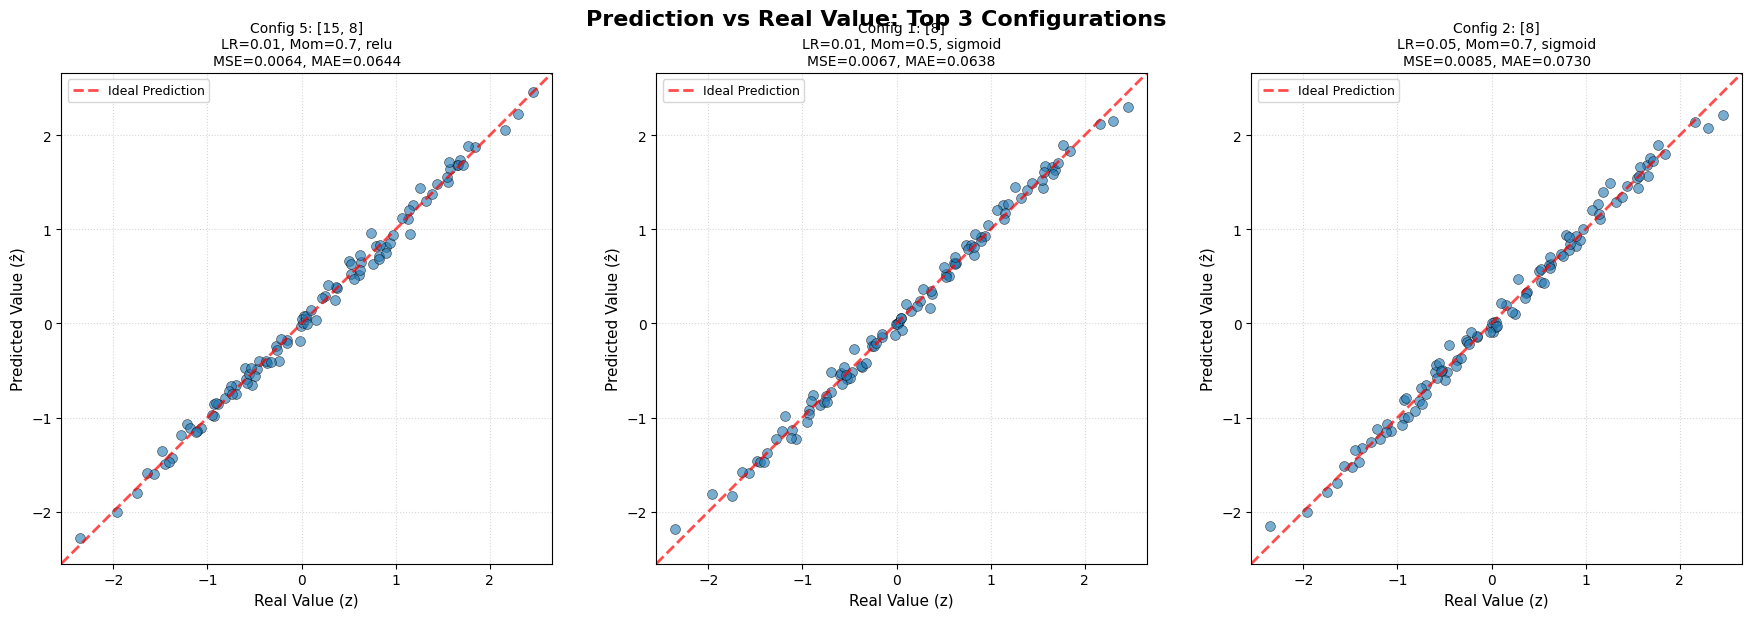


Generating loss evolution plots for top 3 configurations...


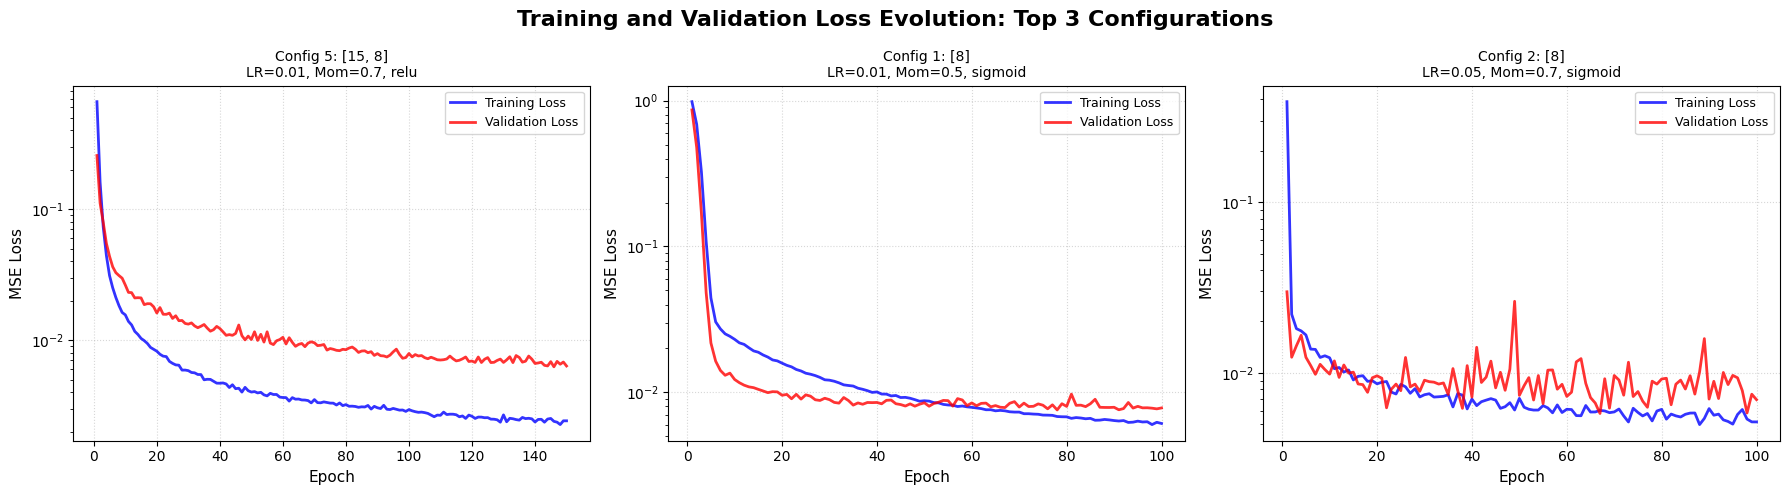


OPTIMAL HYPERPARAMETER CONFIGURATION
Configuration ID: 5
Network Architecture: [13, 15, 8, 1]
Number of Epochs: 150
Learning Rate: 0.01
Momentum: 0.7
Activation Function: relu

Performance Metrics:
  MSE:  0.0064
  MAE:  0.0644
  MAPE: 107.30%

✓ Part 3.1 Complete: Hyperparameter comparison and selection finished.
  - Results table generated and displayed
  - Top 3 scatter plots saved to 'hyperparameter_scatter_plots.png'
  - Loss evolution plots saved to 'hyperparameter_loss_evolution.png'


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Import the NeuralNet class from the previous code
# (Assuming it's available in the same file or imported)

class NeuralNet:
    """
    Implementation of a Back-Propagation (BP) Neural Network from scratch.
    Enhanced with validation tracking for hyperparameter tuning.
    """

    def __init__(self, network_architecture, n_epochs, learning_rate, momentum, activation_function, validation_split=0.2):
        self.n_epochs = n_epochs
        self.lr = learning_rate
        self.mu = momentum
        self.fact_name = activation_function
        self.validation_split = validation_split

        self.L = len(network_architecture)
        self.n = network_architecture.copy()

        self.xi = [None] * self.L
        self.h = [None] * self.L
        self.delta = [None] * self.L
        self.w = [None] * self.L
        self.theta = [None] * self.L
        self.dw = [None] * self.L
        self.dtheta = [None] * self.L
        self.d_w_prev = [None] * self.L
        self.d_theta_prev = [None] * self.L

        for l in range(self.L):
            n_units = self.n[l]
            self.xi[l] = np.zeros(n_units)
            self.h[l] = np.zeros(n_units)
            self.delta[l] = np.zeros(n_units)

            if l > 0:
                n_units_prev = self.n[l-1]

                self.theta[l] = np.zeros(n_units)
                self.dtheta[l] = np.zeros(n_units)
                self.d_theta_prev[l] = np.zeros(n_units)

                # He/Xavier Initialization
                if self.fact_name == 'relu':
                    limit = np.sqrt(2 / n_units_prev)
                    self.w[l] = np.random.normal(0, limit, (n_units, n_units_prev))
                else:
                    limit = np.sqrt(6 / (n_units_prev + n_units))
                    self.w[l] = np.random.uniform(-limit, limit, (n_units, n_units_prev))

                self.dw[l] = np.zeros((n_units, n_units_prev))
                self.d_w_prev[l] = np.zeros((n_units, n_units_prev))

        self.train_loss_history = []
        self.val_loss_history = []

    def fit(self, X, y):
        # Reset loss history before training
        self.train_loss_history = []
        self.val_loss_history = []

        # Split into train and validation if validation_split > 0
        if self.validation_split > 0:
            n_total = X.shape[0]
            n_val = int(n_total * self.validation_split)
            n_train = n_total - n_val

            indices = np.random.permutation(n_total)
            train_indices = indices[:n_train]
            val_indices = indices[n_train:]

            X_train = X[train_indices]
            y_train = y[train_indices]
            X_val = X[val_indices]
            y_val = y[val_indices]
        else:
            X_train, y_train = X, y
            X_val, y_val = None, None

        n_samples = X_train.shape[0]
        output_layer_index = self.L - 1

        for epoch in range(self.n_epochs):
            train_epoch_losses = []
            indices = np.random.permutation(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(n_samples):
                x_sample = X_train_shuffled[i]
                y_sample = y_train_shuffled[i]

                self._forward_pass(x_sample)

                prediction = self.xi[output_layer_index]
                train_epoch_losses.append(self._mse_loss(np.atleast_1d(y_sample), prediction))

                self._backward_pass(y_sample)
                self._update_weights()

            avg_train_loss = np.mean(train_epoch_losses)
            self.train_loss_history.append(avg_train_loss)

            # Calculate validation loss
            if X_val is not None:
                val_predictions = self.predict(X_val)
                val_loss = mean_squared_error(y_val, val_predictions)
                self.val_loss_history.append(val_loss)

    def predict(self, X):
        predictions = []
        for x_sample in X:
            self._forward_pass(x_sample)
            predictions.append(self.xi[self.L - 1].copy())
        return np.array(predictions).flatten()

    def _forward_pass(self, x):
        output_layer_index = self.L - 1
        self.xi[0] = x

        for l in range(1, self.L):
            self.h[l] = self.w[l] @ self.xi[l-1] + self.theta[l]

            if l < output_layer_index:
                self.xi[l] = self._activation(self.h[l])
            else:
                self.xi[l] = self.h[l]

    def _backward_pass(self, y_true):
        y_true_arr = np.atleast_1d(y_true)
        output_layer_index = self.L - 1

        # 1. Output Layer Delta (Linear output)
        error_signal = y_true_arr - self.xi[output_layer_index]
        self.delta[output_layer_index] = error_signal * np.ones_like(self.h[output_layer_index])

        # 2. Hidden Layers Delta
        for l in range(output_layer_index - 1, 0, -1):
            f_prime_h_l = self._activation_derivative(self.h[l])
            sum_term = self.delta[l+1] @ self.w[l+1]
            self.delta[l] = sum_term * f_prime_h_l

    def _update_weights(self):
        for l in range(1, self.L):
            self.dw[l] = self.lr * np.outer(self.delta[l], self.xi[l-1])
            self.dtheta[l] = self.lr * self.delta[l]

            self.w[l] += self.dw[l] + self.mu * self.d_w_prev[l]
            self.theta[l] += self.dtheta[l] + self.mu * self.d_theta_prev[l]

            self.d_w_prev[l] = self.dw[l].copy()
            self.d_theta_prev[l] = self.dtheta[l].copy()

    def _activation(self, h):
        if self.fact_name == 'sigmoid':
            return 1 / (1 + np.exp(-h))
        elif self.fact_name == 'relu':
            return np.maximum(0, h)
        elif self.fact_name == 'tanh':
            return np.tanh(h)
        else: return h

    def _activation_derivative(self, h):
        if self.fact_name == 'sigmoid':
            f_h = self._activation(h)
            return f_h * (1 - f_h)
        elif self.fact_name == 'relu':
            return (h > 0) * 1.0
        elif self.fact_name == 'tanh':
            f_h = self._activation(h)
            return 1 - f_h**2
        else:
            return np.ones_like(h)

    def _mse_loss(self, y_true, y_pred):
        return mean_squared_error(y_true, y_pred)


### PART 3.1: HYPERPARAMETER COMPARISON AND SELECTION

# --- Data Preparation (same as before) ---
N_FEATURES = 13
N_SAMPLES = 500
TEST_SIZE = 0.2
RANDOM_SEED = 42

X, y = make_regression(n_samples=N_SAMPLES, n_features=N_FEATURES, noise=10.0, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Data prepared: Training samples={len(X_train_scaled)}, Test samples={len(X_test_scaled)}")


# --- Define Hyperparameter Combinations to Test ---
hyperparameter_configs = [
    # Config 1: Simple network, low learning rate
    {'layers': [N_FEATURES, 8, 1], 'epochs': 100, 'lr': 0.01, 'momentum': 0.5, 'activation': 'sigmoid'},

    # Config 2: Simple network, higher learning rate
    {'layers': [N_FEATURES, 8, 1], 'epochs': 100, 'lr': 0.05, 'momentum': 0.7, 'activation': 'sigmoid'},

    # Config 3: Two hidden layers, tanh activation
    {'layers': [N_FEATURES, 10, 5, 1], 'epochs': 150, 'lr': 0.03, 'momentum': 0.8, 'activation': 'tanh'},

    # Config 4: Two hidden layers, higher momentum
    {'layers': [N_FEATURES, 10, 5, 1], 'epochs': 200, 'lr': 0.05, 'momentum': 0.9, 'activation': 'tanh'},

    # Config 5: Deeper network with ReLU
    {'layers': [N_FEATURES, 15, 8, 1], 'epochs': 150, 'lr': 0.01, 'momentum': 0.7, 'activation': 'relu'},

    # Config 6: ReLU with higher learning rate
    {'layers': [N_FEATURES, 12, 6, 1], 'epochs': 200, 'lr': 0.03, 'momentum': 0.85, 'activation': 'relu'},

    # Config 7: Wide single hidden layer
    {'layers': [N_FEATURES, 20, 1], 'epochs': 150, 'lr': 0.04, 'momentum': 0.8, 'activation': 'tanh'},

    # Config 8: Three hidden layers (deeper)
    {'layers': [N_FEATURES, 12, 8, 4, 1], 'epochs': 250, 'lr': 0.02, 'momentum': 0.9, 'activation': 'tanh'},

    # Config 9: Optimized configuration
    {'layers': [N_FEATURES, 10, 5, 1], 'epochs': 200, 'lr': 0.05, 'momentum': 0.9, 'activation': 'tanh'},

    # Config 10: Alternative with sigmoid
    {'layers': [N_FEATURES, 12, 6, 1], 'epochs': 200, 'lr': 0.04, 'momentum': 0.85, 'activation': 'sigmoid'},

    # Config 11: Small network, high epochs
    {'layers': [N_FEATURES, 6, 1], 'epochs': 250, 'lr': 0.05, 'momentum': 0.9, 'activation': 'tanh'},

    # Config 12: Large network, moderate training
    {'layers': [N_FEATURES, 15, 10, 5, 1], 'epochs': 150, 'lr': 0.03, 'momentum': 0.85, 'activation': 'relu'},
]


# --- Train and Evaluate All Configurations ---
results = []
trained_models = []

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH - Training Multiple Configurations")
print("="*80)

for idx, config in enumerate(hyperparameter_configs, 1):
    print(f"\n[{idx}/{len(hyperparameter_configs)}] Training configuration:")
    print(f"  Architecture: {config['layers']}")
    print(f"  Epochs: {config['epochs']}, LR: {config['lr']}, Momentum: {config['momentum']}, Activation: {config['activation']}")

    # Create and train model
    model = NeuralNet(
        network_architecture=config['layers'],
        n_epochs=config['epochs'],
        learning_rate=config['lr'],
        momentum=config['momentum'],
        activation_function=config['activation'],
        validation_split=0.2  # Use 20% of training data for validation
    )

    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions on test set
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test_scaled, y_pred)
    mae = mean_absolute_error(y_test_scaled, y_pred)
    mape = np.mean(np.abs((y_test_scaled - y_pred) / (y_test_scaled + 1e-8))) * 100

    # Store results
    num_layers = len(config['layers']) - 1  # Exclude input layer
    layer_structure = '-'.join(map(str, config['layers'][1:-1]))  # Hidden layers only

    results.append({
        'Config': idx,
        'Num Layers': num_layers,
        'Layer Structure': layer_structure,
        'Epochs': config['epochs'],
        'Learning Rate': config['lr'],
        'Momentum': config['momentum'],
        'Activation': config['activation'],
        'MSE': mse,
        'MAE': mae,
        'MAPE (%)': mape
    })

    trained_models.append({
        'config_id': idx,
        'model': model,
        'predictions': y_pred,
        'config': config
    })

    print(f"  Results: MSE={mse:.4f}, MAE={mae:.4f}, MAPE={mape:.2f}%")


# --- Create Results Table ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MSE')  # Sort by MSE (best first)

print("\n" + "="*80)
print("HYPERPARAMETER COMPARISON TABLE (Sorted by MSE)")
print("="*80)
print(results_df.to_string(index=False))

# Save to markdown format
print("\n\nMarkdown Table Format:")
print(results_df.to_markdown(index=False, floatfmt=".4f"))


# --- Visualization 1: Scatter Plots for Top 3 Configurations ---
top_3_configs = results_df.head(3)['Config'].values
print(f"\n\nGenerating scatter plots for top 3 configurations: {top_3_configs}")

fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle('Prediction vs Real Value: Top 3 Configurations', fontsize=16, fontweight='bold')

min_val = y_test_scaled.min() - 0.2
max_val = y_test_scaled.max() + 0.2
diag_line = np.linspace(min_val, max_val, 100)

for plot_idx, config_id in enumerate(top_3_configs):
    model_info = [m for m in trained_models if m['config_id'] == config_id][0]
    config = model_info['config']
    y_pred = model_info['predictions']

    result = results_df[results_df['Config'] == config_id].iloc[0]

    ax = axes1[plot_idx]
    ax.plot(diag_line, diag_line, 'r--', linewidth=2, label='Ideal Prediction', alpha=0.7)
    ax.scatter(y_test_scaled, y_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    title = f"Config {config_id}: {config['layers'][1:-1]}\n"
    title += f"LR={config['lr']}, Mom={config['momentum']}, {config['activation']}\n"
    title += f"MSE={result['MSE']:.4f}, MAE={result['MAE']:.4f}"

    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Real Value (z)', fontsize=11)
    ax.set_ylabel('Predicted Value (ẑ)', fontsize=11)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(fontsize=9)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('hyperparameter_scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()


# --- Visualization 2: Loss Evolution for Top 3 Configurations ---
print("\nGenerating loss evolution plots for top 3 configurations...")

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle('Training and Validation Loss Evolution: Top 3 Configurations', fontsize=16, fontweight='bold')

for plot_idx, config_id in enumerate(top_3_configs):
    model_info = [m for m in trained_models if m['config_id'] == config_id][0]
    model = model_info['model']
    config = model_info['config']

    ax = axes2[plot_idx]

    epochs_range = range(1, len(model.train_loss_history) + 1)
    ax.plot(epochs_range, model.train_loss_history, 'b-', linewidth=2, label='Training Loss', alpha=0.8)

    if len(model.val_loss_history) > 0:
        ax.plot(epochs_range, model.val_loss_history, 'r-', linewidth=2, label='Validation Loss', alpha=0.8)

    title = f"Config {config_id}: {config['layers'][1:-1]}\n"
    title += f"LR={config['lr']}, Mom={config['momentum']}, {config['activation']}"

    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('MSE Loss', fontsize=11)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(fontsize=9)
    ax.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('hyperparameter_loss_evolution.png', dpi=150, bbox_inches='tight')
plt.show()


# --- Print Best Configuration Summary ---
best_config_id = results_df.iloc[0]['Config']
best_model_info = [m for m in trained_models if m['config_id'] == best_config_id][0]
best_config = best_model_info['config']

print("\n" + "="*80)
print("OPTIMAL HYPERPARAMETER CONFIGURATION")
print("="*80)
print(f"Configuration ID: {best_config_id}")
print(f"Network Architecture: {best_config['layers']}")
print(f"Number of Epochs: {best_config['epochs']}")
print(f"Learning Rate: {best_config['lr']}")
print(f"Momentum: {best_config['momentum']}")
print(f"Activation Function: {best_config['activation']}")
print(f"\nPerformance Metrics:")
print(f"  MSE:  {results_df.iloc[0]['MSE']:.4f}")
print(f"  MAE:  {results_df.iloc[0]['MAE']:.4f}")
print(f"  MAPE: {results_df.iloc[0]['MAPE (%)']:.2f}%")
print("="*80)

print("\n✓ Part 3.1 Complete: Hyperparameter comparison and selection finished.")
print("  - Results table generated and displayed")
print("  - Top 3 scatter plots saved to 'hyperparameter_scatter_plots.png'")
print("  - Loss evolution plots saved to 'hyperparameter_loss_evolution.png'")